In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import os 
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
from IPython import display

In [2]:
# generator model creation funciton
# NOTE: this model is taken off the tensorflow website and might not be what we need at the moment 

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1) ### this is the output shape
    
    return model
    
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
    


tf.Tensor([[0.00188593]], shape=(1, 1), dtype=float32)


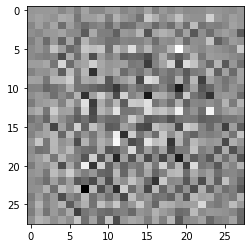

In [3]:
## testing to make sure the model can produce random images 

discriminator = make_discriminator_model()

generator = make_generator_model()

noise  = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

decision = discriminator(generated_image)
print (decision)



In [4]:
##loss functions

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)  ## helper function to get crossentropy loss

def discriminator_loss(real_output, fake_output):  ##dicriminator takes total loss of both the real image and fake image
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # loss for real image to an array of ones
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # loss for the fake output as an array of zeros
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  ##  oposite for the generator  as its loss is compated to an array of ones


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)




In [6]:
## checkpoint system

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
@tf.function
def train_step(images): ## one batch of an epoch 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])   ## calculate noise for batch
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # get gradient tapes
        generated_images = generator(noise, training=True)  ## generate images
        real_output = discriminator(images, training=True)   ## discriminate for both images
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)   ### calculate loss for  both
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)   ## develop gradient 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  ### apply gradient with optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs): ### training per epoch
        start = time.time()

        for image_batch in dataset:  ## trains one batch at a time
            train_step(image_batch)
        display.clear_output(wait=True)    ## after one batch, save image to look back at later 
        generate_and_save_images(generator,epoch + 1,seed)
        if (epoch + 1) % 15 == 0:    
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)      ### we can delete these display calls if we don't want to see whats going on in real time
    generate_and_save_images(generator,epochs,seed)

In [9]:
### training loop setup:
epochs = 50
noise_dim=100
BATCH_SIZE = 32
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])





In [10]:
## call training



In [11]:
## generate images:
display_image(epochs) # displays the final image
 

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'